<hr>
Este material ha sido construido en conjunto con material suministrado por los profesores Pedro Atencio (Instituto Tecnológico Metropolitano), Carlos Mera (Instituto Tecnológico Metropolitano), Albeiro Espinosa y Diego Patiño (Universidad Nacional de Colombia, Sede Medellín); a ellos les damos crédito.
<hr>

#  <center> VISIÓN ARTIFICIAL </center>
## Agenda del día


### UNIDAD 11 - SELECCIÓN DE CARACTERÍSTICAS E INTRODUCCIÓN AL RECONOCIMIENTO DE PATRONES

<ul>
  <li>Repaso extracción</li>
  <li>Selección de características</li>
  <li>Introducción al reconocimiento de patrones</li>

</ul>

In [ ]:
#Lectura de librerías útiles
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
from skimage import morphology
from skimage.measure import label, regionprops
import pandas as pd
warnings.filterwarnings('ignore')

#Definir funciones que agilizan la lectura de imágenes
def img_read(filename, mode = 'color'):
    if(mode == 'color'):
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        return None

<img src = res/intro.png>

En esta sesión haremos uso del conjunto de datos MNIST para ejemplificar las fases de extracción, selección y clasificación.

Este conjunto de datos está conformado por 70.000 imágenes de dígitos del 0 al 9 escritos a mano. La tarea es, pues, clasificar los dígitos.

<img src = res/digitos.png>

# 1.0 REPASO DE SEGMENTACIÓN/EXTRACCIÓN DE CARACTERÍSTICAS

A continuación, repasemos el proceso de extracción de características para los dígitos del conjunto de datos MNIST. Para esto, hacemos uso de la librería Keras, la cual tiene el conjunto listo para ser utilizado.

Keras devuelve los datos en forma de un conjunto de entrenamiento  (x_train, y_train) de 70000 entradas donde cada entrada de entrenamiento $x_i$ es una matriz conformada por 28x28 píxeles, y cada etiqueta de entrenamiento $y_i$ es un número del 0 al 9 indicando la clase de la entrada correspondiente.

El conjunto de prueba (x_test, y_test) se puede describir de la misma forma, con la salvedad de que está conformado por 10000 entradas.

In [ ]:
#Importar datasets preparados para trabajar
from keras.datasets import mnist

#Cargar el dataset, conjuntos de entrenamiento y pruebas
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Imprimir resultados de entrenamiento (labels)
print("Conjunto de entrenamiento: ", x_train.shape)
print("Etiquetas de entrenamiento: ", y_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Conjunto de entrenamiento:  (60000, 28, 28)
Etiquetas de entrenamiento:  (60000,)


In [ ]:
print("Conjunto de prueba: ", x_test.shape)
print("Etiquetas de prueba: ", y_test.shape)

Conjunto de prueba:  (10000, 28, 28)
Etiquetas de prueba:  (10000,)


# 1.1 SEGMENTACIÓN

Para este caso de estudio, la segmentación es trivial pero en todo caso necesaria.

Examinemos una imagen del conjunto de entrenamiento:

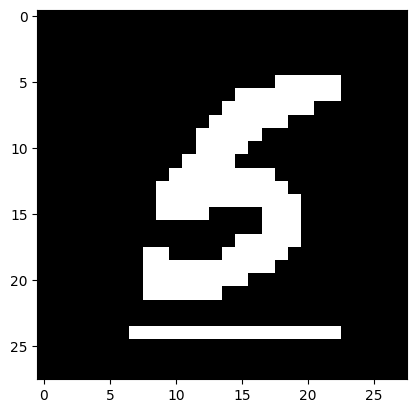

In [ ]:
#Mostrar una imagen del dataset de entrenamiento
im = x_train[775]
plt.imshow(im, cmap='gray')

Los gradientes de intensidad en los bordes de la imagen no contienen información que nos sea demasiado útil para trabajar con las imágenes. Por este motivo, aplicamos una umbralización simple de manera que podamos extraer características a partir de la máscara binaria.

In [ ]:
#Extraer máscara binaria de todos los elementos de entrenamiento y pruebas

for i in range(len(x_train)):
    x_train[i][x_train[i]>0.1] = 1
    x_train[i][x_train[i]<=0.1] = 0

for i in range(len(x_test)):
    x_test[i][x_test[i]>0.1] = 1
    x_test[i][x_test[i]<=0.1] = 0

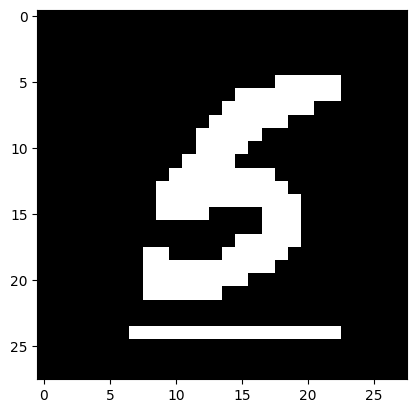

In [ ]:
plt.imshow(x_train[775], cmap='gray')

# 1.2 MORFOLOGÍA

Como vemos arriba, algunas de las imágenes resultantes tienen componentes que no son de interés. De manera empírica definimos eliminar los componentes que no son de interés mediante la operación <i>remove small objects</i> de la librería scikit-image.

En algunas imágenes de ceros, el círculo no está cerrado completamente, sin embargo, decidimos no implementar funciones de morfología para corregir dichos errores puesto que esto puede incidir negativamente en imágenes donde los huecos sean pequeños.

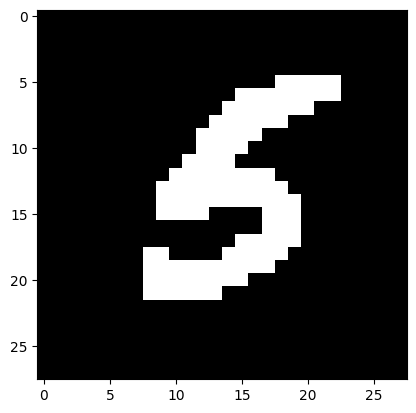

In [ ]:
#Aplicar remoción de objetos pequeños sobre las imágenes binarias
img = x_train[775]
img *= morphology.remove_small_objects(img.astype(bool), min_size = 50)
plt.imshow(img, cmap = 'gray')

# 1.3 EXTRACCIÓN DE CARACTERÍSTICAS

Ya que el conjunto de imágenes MNIST no contiene información de color o textura que nos sea de utilidad, nos centraremos en el uso de descriptores de forma y topología.

## 1.3.1 MOMENTOS DE HU

Como se vio en la sesión anterior, los momentos de Hu son los momentos más útiles para tareas de clasificación al ser invariantes al tamaño, la rotación y la traslación.

Adicionalmente, tomamos el logaritmo de los mismos para garantizar que se mantengan en un rango de valores razonable.

In [ ]:
#definir función que extrae los momentos

def get_moments_hu(props, features):
    moments_hu = props.moments_hu
    moments_hu = np.sign(moments_hu) * np.log(np.abs(moments_hu))
    features['hu0'] = moments_hu[0]
    features['hu1'] = moments_hu[1]
    features['hu2'] = moments_hu[2]
    features['hu3'] = moments_hu[3]
    features['hu4'] = moments_hu[4]
    features['hu5'] = moments_hu[5]
    features['hu6'] = moments_hu[6]
    return features

## 1.3.2 CARACTERÍSTICAS TOPOLÓGICAS

Entre las características topológicas, la de mayor interés es el número de euler (1 - la cantidad de huecos en el objeto). Decidimos no usar el número de huecos, ya que está correlacionado con el número de huecos.

In [ ]:
#obtener propiedades topológicas de la imagen

def get_features_topological(props, features):
    features['euler_num'] = props.euler_number
    return features


## 1.3.3 CARACTERÍSTICAS DE FORMA



In [ ]:
#función de características de forma

def get_features_area(props, features):

    features['orientation'] = props.orientation
    features['area_to_convex_ratio'] = props.area/props.convex_area
    features['compacity'] = props.perimeter**2/props.area
    features['roundness'] = 4*math.pi*props.area /(props.perimeter**2)
    #print(i)
    features['area_perimeter_ratio'] = props.area / props.perimeter
    features['elongation'] = props.major_axis_length/props.minor_axis_length
    features['solidity1'] = props.area/props.convex_area
    features['solidity2'] = props.area / props.filled_area
    return features

# JUNTANDO LO ANTERIOR

Combinamos lo anterior (excepto umbralización) en una sola función get_features en la que se aplicamos morfología y extracción de las características.

Esta función de vuelve un diccionario de características <i>features</i> con las características extraidas de una imagen del conjunto de datos.



In [ ]:
#función que extrae características de una imagen

def get_features(img):
  features = {}
  img *= morphology.remove_small_objects(img.astype(bool), min_size = 20)
  label_img = label(img)
  props = regionprops(label_img)[0]
    features = get_moments_hu(props, features)
    features = get_features_topological(props, features)
    features = get_features_area(props, features)
    return features

features_0 = get_features(x_train[0])
columns = list(features_0.keys())
columns.append('class')

#crear dataset de características de entrenamiento como dataframe de pandas
df_train = pd.DataFrame(columns=columns)

#extraer características de todas las imágenes de entrenamiento
for i in range(len(x_train)):
    features = get_features(x_train[i])
    df_train.loc[i] = [features[feature] for feature in features.keys()]+[y_train[i]]

In [ ]:
#volverlo un csv
df_train.to_csv('data_train.csv')

In [ ]:
#leer el set como un dataframe de pandas
df_train = pd.read_csv('data_train.csv')

In [ ]:
#mostrar los primeros ID del dataset
df_train.head()

,Unnamed: 0,hu0,hu1,hu2,hu3,hu4,hu5,hu6,euler_num,orientation,area_to_convex_ratio,compacity,roundness,area_perimeter_ratio,elongation,solidity1,solidity2,class
0,0,-1.030334,-3.382183,-5.921228,-7.284824,-14.569056,-9.615941,-14.035736,1,-0.314864,0.544262,51.040868,0.246202,1.803412,1.770921,0.544262,1.000000,5
1,1,-1.152595,-4.044950,-7.522026,-8.279011,18.609868,-10.516197,16.183418,0,-0.600123,0.676923,55.701218,0.225603,1.777559,1.562802,0.676923,0.709677,0
2,2,-0.658067,-3.536645,-2.466380,-5.307169,-9.844151,-7.455273,-9.352959,1,1.431272,0.404040,56.511648,0.222368,1.457208,1.408097,0.404040,1.000000,4
3,3,-0.769493,-1.684218,-6.996959,-8.666822,-17.579829,11.850399,-16.559834,1,-0.543694,0.800000,29.765909,0.422173,1.795875,5.249216,0.800000,1.000000,1
4,4,-1.262993,-4.296575,-4.179752,-6.115294,-11.306249,-8.477602,12.506082,0,0.050033,0.663551,45.941695,0.273529,1.758088,1.550739,0.663551,0.934211,9


In [ ]:
#extraer la parte del dataset que corresponde a pruebas
df_test = pd.DataFrame(columns=columns)

#obtener las características de las imágenes de prueba
for i in range(len(x_test)):
    features = get_features(x_test[i])
    df_test.loc[i] = [features[feature] for feature in features.keys()]+[y_test[i]]


In [ ]:
#guardar como csv
df_test.to_csv('data_test.csv')

In [ ]:
#leer el csv
df_test = pd.read_csv('data_test.csv')

# 2.0 SELECCIÓN DE CARACTERÍSTICAS

El problema de selección de características puede entenderse como una instancia del problema de la mochila.

<img src = res/pesos.png>

# 2.1. ENFOQUES ESTADÍSTICOS

Se le asigna un puntaje estadístico a cada característica con base en una medición estadística, por ejemplo:

- Varianza $\sigma^2$
- Chi-Cuadrado $\chi^2$
- Anova.
- Entropia.
- etc.

Para ejemplificar los conceptos de selección de características, utilizaremos algunos casos más sencillos...

## 2.1.1. SELECCIÓN DE CARACTERÍSTICAS POR VARIANZA

In [ ]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold

#crear una array de numpy
X = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]])

#aplicar selector de características por varianza
selector = VarianceThreshold(threshold=0.2)
X_new = selector.fit_transform(X)
print("Original features: ",X)
print("Selected features: ",X_new)

Original features:  [[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 1]
 [0 1 0]
 [0 1 1]]
Selected features:  [[0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]]


In [ ]:
from sklearn.datasets import load_iris
from tabulate import tabulate

#cargar un dataset de iris
iris = load_iris()

#extraer las características del dataset escogido
X, y = iris.data, iris.target
#imprimir una tabla
headers = ["feature 1", "feature 2", "feature 3", "feature 4"]
table = tabulate(X[0:5,:], headers, tablefmt="fancy_grid")
print(table)

╒═════════════╤═════════════╤═════════════╤═════════════╕
│   feature 1 │   feature 2 │   feature 3 │   feature 4 │
╞═════════════╪═════════════╪═════════════╪═════════════╡
│         5.1 │         3.5 │         1.4 │         0.2 │
├─────────────┼─────────────┼─────────────┼─────────────┤
│         4.9 │         3   │         1.4 │         0.2 │
├─────────────┼─────────────┼─────────────┼─────────────┤
│         4.7 │         3.2 │         1.3 │         0.2 │
├─────────────┼─────────────┼─────────────┼─────────────┤
│         4.6 │         3.1 │         1.5 │         0.2 │
├─────────────┼─────────────┼─────────────┼─────────────┤
│         5   │         3.6 │         1.4 │         0.2 │
╘═════════════╧═════════════╧═════════════╧═════════════╛


In [ ]:
selector = VarianceThreshold(threshold=0.6) #selección de características
X_new = selector.fit_transform(X)

sel_features = np.squeeze(np.where(selector.get_support()==True)) #Cuando es verdad la selección?

#mostrar características seleccionadas
print("Features selected: ", sel_features)
print(selector.get_support())

Features selected:  [0 2]
[ True False  True False]


In [ ]:
#imprimir las características seleccionadas como tablas
headers = ["feature "+str(i+1) for i in sel_features]
table = tabulate(X_new[0:5,], headers, tablefmt="fancy_grid")
print(table)

╒═════════════╤═════════════╕
│   feature 1 │   feature 3 │
╞═════════════╪═════════════╡
│         5.1 │         1.4 │
├─────────────┼─────────────┤
│         4.9 │         1.4 │
├─────────────┼─────────────┤
│         4.7 │         1.3 │
├─────────────┼─────────────┤
│         4.6 │         1.5 │
├─────────────┼─────────────┤
│         5   │         1.4 │
╘═════════════╧═════════════╛


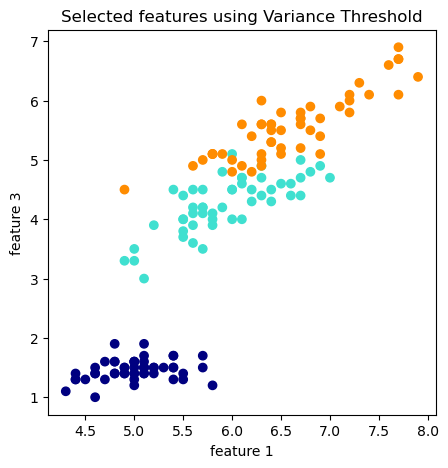

In [ ]:
import matplotlib.pyplot as plt

#Realizar la impresión de la característica 1 vs la característica 3 escogidas
colors = ['navy', 'turquoise', 'darkorange']

target_names = iris.target_names

color = [colors[i] for i in y]
label = [target_names[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Selected features using Variance Threshold")

plt.scatter(X_new[:, 0], X_new[:, 1], color=color)

plt.xlabel("feature "+str(sel_features[0]+1))
plt.ylabel("feature "+str(sel_features[1]+1))
plt.show()

## 2.1.2. SELECCIÓN POR PRUEBA ESTADÍSTICA $\chi^2$

Se pueden utilizar técnicas estadísticas como chi-cuadrado $\chi^2$ para seleccionar características. Esta prueba responde la siguiente pregunta:<br/><br/>

<center> <font size=5>¿Qué tan independientes son las variables de la respuesta? </font></center>

Se busca el mayor aporte de información/mayor correlación con respecto a la variable de respuesta.

<br>



In [ ]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

#realizar una lectura del dataset de iris
iris = load_iris()

X, y = iris.data, iris.target

k=2 #best 2 independets features

#Utilizar como selector de características los K vecinos mejores
selector = SelectKBest(score_func=chi2, k=2)

X_new = selector.fit_transform(X, y)

sel_features = np.squeeze(np.where(selector.get_support()==True)) #Where selection is True?

sel_features

array([2, 3], dtype=int64)

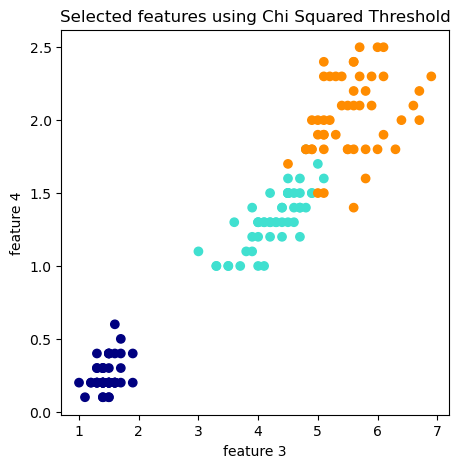

In [ ]:
#Imprimir features escogidos en forma gráfica
colors = ['navy', 'turquoise', 'darkorange']

target_names = iris.target_names

color = [colors[i] for i in y]
label = [target_names[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Selected features using Chi Squared Threshold")

plt.scatter(X_new[:, 0], X_new[:, 1], color=color)

plt.xlabel("feature "+str(sel_features[0]+1))
plt.ylabel("feature "+str(sel_features[1]+1))
plt.show()

# 3. WRAPPERS Y MODELOS EMBEBIDOS

## 3.1. WRAPPERS

Se utiliza un modelo predictivo para evaluar diferentes combinaciones de características a partir de un método de búsqueda. Por ejemplo: selección hacia adelante, selección hacia atrás, etc. Cuando un conjunto dado de combinaciones ha sido probado, se selecciona el mejor subconjunto de características.

El método se ejecuta en k iteraciones de manera recursiva y el número de características es el definido por el usuario.

<img src = res/wrapper.png>

In [ ]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

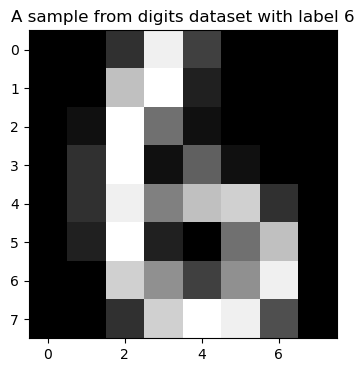

In [ ]:
index = 234
img = np.reshape(X[index,:], (8,8))
label = y[index]
# Plot pixel ranking
plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray')
plt.title("A sample from digits dataset with label "+str(label))
plt.show()

In [ ]:
# Create the RFE object and rank each pixel
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=32, step=1) #mejores 32 características
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)
print(ranking)

[[33 18  1  2  1  1  1 20]
 [25  7  9  1  1 15  4 22]
 [21  8  5  1  1  1  1 24]
 [23 12  1  1  1  1  1 29]
 [32  1  6  1  1  1  1 31]
 [28  1  1  1  1 10  1 26]
 [27 14 13  1  1  1  3 17]
 [30 19  1  1 11  1  1 16]]


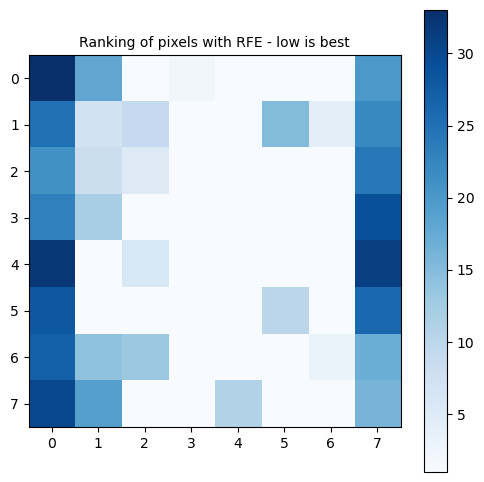

In [ ]:
#Plotear el ranking de pixeles, los menores valores son los mejores
plt.figure(figsize=(6,6))
plt.imshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE - low is best", fontsize=10)
plt.show()

## 3.2. MODELOS EMBEBIDOS

Se hace uso del modelo predictivo para dos tareas al mismo tiempo: para evaluar el rendimiento del subconjunto y para **aprender** cual subconjunto es el mejor.

Ejemplos: Regresiones con Penalización Lasso/Ridge, Arboles de Decisión.

<img src = res/embebido.png>

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectFromModel

In [ ]:
#load digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

#train prediction model
predictor = ExtraTreesClassifier()
predictor.fit(X, y)

ExtraTreesClassifier()

In [ ]:
model = SelectFromModel(predictor, threshold=0.02, prefit=True)
X_new = model.transform(X) #dataset with selected features

In [ ]:
selection = model.get_support()
selection_map = np.reshape(selection, (8,8))

num_selected_features = np.count_nonzero(selection)

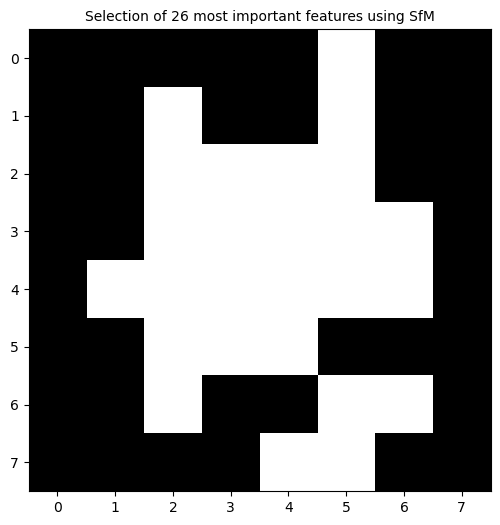

In [ ]:
# Plot pixel ranking
plt.figure(figsize=(6,6))
plt.imshow(selection_map, cmap='gray')
plt.title("Selection of "+str(num_selected_features)+" most important features using SfM", fontsize=10)
plt.show()

# 4. TRANSFORMACIONES PARA REDUCCIÓN

La transformación de características consiste en obtener un conjunto de características G a partir de una transformación lineal o no-lineal de un conjunto de datos X.

<img src = res/redu.png>


## 4.1. ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)

Esta técnica consiste en proyectar un conjunto de datos sobre un hiperespacio compuesto por las dimensiones principales de los datos.

¿Cuáles $\lambda_i \in V$ son mejores?

<img src = res/pers.png>

Text(0.5, 0, '$f_2$')

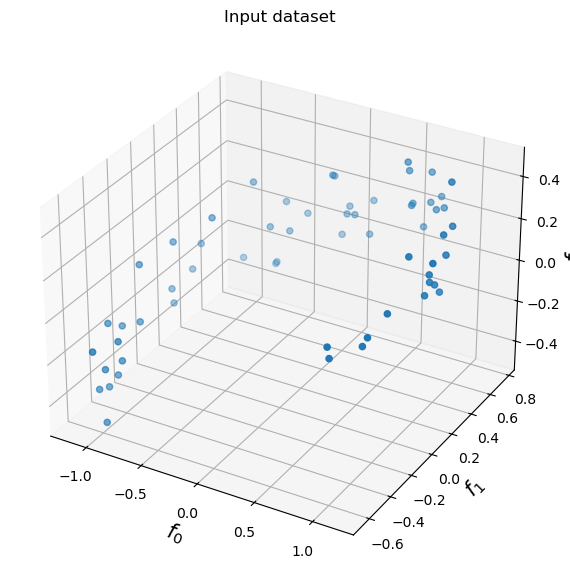

In [ ]:
#generate a test dataset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2])

ax.set_title("Input dataset")
ax.set_xlabel(r'$f_0$', fontsize=15)
ax.set_ylabel(r'$f_1$', fontsize=15)
ax.set_zlabel(r'$f_2$', fontsize=15)

##  4.2. PCA USANDO DESCOMPOSICIÓN EN VALORES SINGULARES

Los valores propios pueden ser extraidos usando una factorización de matrices. Por ejemplo, la descomposición en valores singulares, que se puede expresar como:



$X = U \cdot \sum \cdot V^T$

Donde $V$ es la matriz que contiene los valores propios de $X$

$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

In [ ]:
from numpy.linalg import svd

# Apply Single Value Decomposition over X
X_centered = X - X.mean(axis=0)
U, s, Vt = svd(X_centered)

In [ ]:
print(Vt) #valores propios

[[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]
 [-0.08626012 -0.31420255  0.94542898]]


Una vez extraida $V$, podemos proyectar la matriz X sobre uno o más valores propios o componentes principales para reducir la dimensionalidad de X:

$ X_{new} = X \cdot V^{'} $

In [ ]:
#Project X over first principal components

V_prime = Vt.T[:, :2]
X2D = np.dot(X_centered, V_prime)

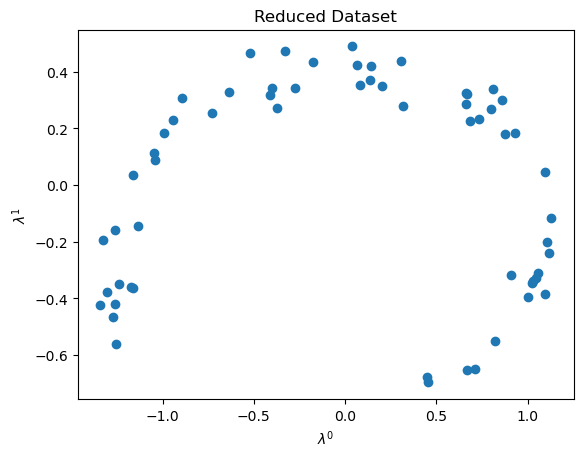

In [ ]:
plt.title("Reduced Dataset")
plt.scatter(X2D[:,0], X2D[:,1])
#Puede ser interpretado como la sombra.
plt.xlabel(r'$\lambda^0$')
plt.ylabel(r'$\lambda^1$')
plt.show()

## 4.3. PCA USANDO SCIKIT-LEARN



In [ ]:
from sklearn.decomposition import PCA

#Aplicar PCA con 2 componentes sobre X
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [ ]:
print("First 2 components by SVD: ",Vt[:2])
print("First 2 components by Scikit: ", pca.components_)

First 2 components by SVD:  [[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]]
First 2 components by Scikit:  [[-0.93636116 -0.29854881 -0.18465208]
 [ 0.34027485 -0.90119108 -0.2684542 ]]


Apliquemos PCA sobre el conjunto de datos Iris.

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target
k=2 #Primeros 2 componentes principales

#Aplicar PCA sobre X
pca = PCA(n_components=k)
X_new = pca.fit_transform(X)

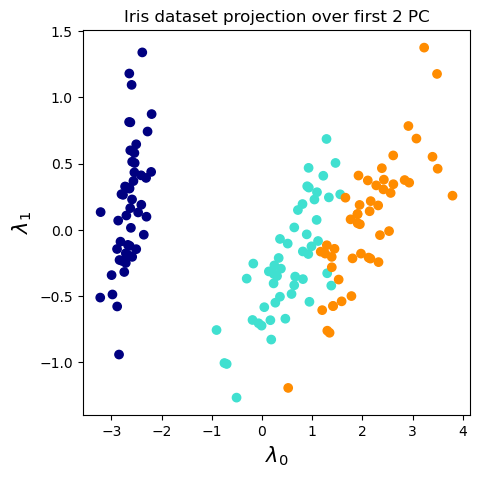

In [ ]:
#Imprimir los dos componentes principales
colors = ['navy', 'turquoise', 'darkorange']

target_names = iris.target_names

color = [colors[i] for i in y]
label = [target_names[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Iris dataset projection over first 2 PC")

plt.scatter(X_new[:, 0], X_new[:, 1], color=color)

plt.xlabel(r'$\lambda_0$', fontsize=15)
plt.ylabel(r'$\lambda_1$', fontsize=15)
plt.show()

<hr>

## 4.4. PCA NO-LINEAL / KERNEL PCA

En casos más complejos, podemos utilizar funciones matemáticas no-lineales o de kernel para realizar transformaciones complejas en los datos.

In [ ]:
from sklearn.datasets import make_circles

In [ ]:
#Seleccionar la semilla
np.random.seed(0)
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

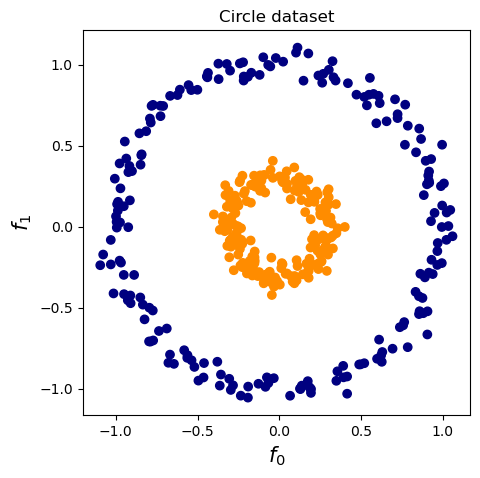

In [ ]:
#Imprimir los datos escogidos
colors = ['navy', 'darkorange']

target_names = iris.target_names

color = [colors[i] for i in y]
label = [target_names[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Circle dataset")

plt.scatter(X[:, 0], X[:, 1], color=color)

plt.xlabel(r'$f_0$', fontsize=15)
plt.ylabel(r'$f_1$', fontsize=15)
plt.show()

Evaluemos el resultado de un PCA simple.

In [ ]:
#Aplicar PCA sobre el set de datos
pca = PCA(n_components=1)
X_new = pca.fit_transform(X)

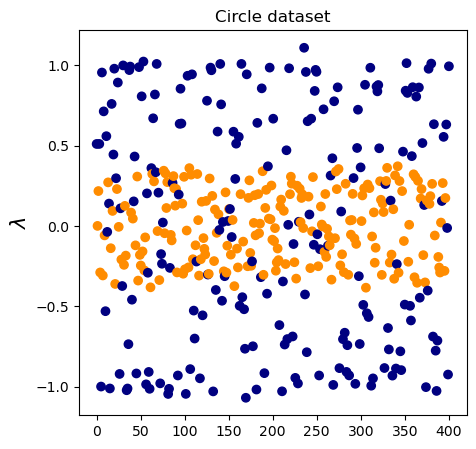

In [ ]:
#Imprimirlo como una imagen 2D
colors = ['navy', 'darkorange']

target_names = iris.target_names

color = [colors[i] for i in y]
label = [target_names[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Circle dataset")

plt.scatter(np.linspace(0,len(X_new),len(X_new)), X_new, color=color)

plt.ylabel(r'$\lambda$', fontsize=15)
plt.show()

Ahora con Kernel PCA:

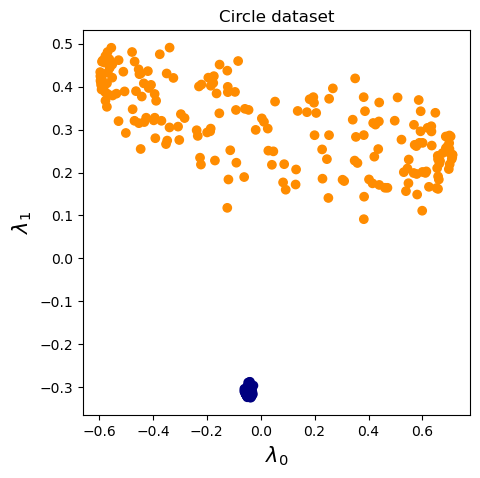

In [ ]:
from sklearn.decomposition import KernelPCA

#Aplicar un kernel PCA no lineal e imprimirlo
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)

colors = ['navy', 'darkorange']

color = [colors[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Circle dataset")

plt.scatter(X_kpca[:, 0], X_kpca[:, 1], color=color)

plt.xlabel(r'$\lambda_0$', fontsize=15)
plt.ylabel(r'$\lambda_1$', fontsize=15)
plt.show()

## 4.5. OTRAS APLICACIONES DE PCA:

En el siguiente enlace se presenta un ejemplo de aplicación de PCA para la reducción de características en imágenes de rostros:

https://alceballosa.shinyapps.io/Trabajo3/

#  5. INTRODUCCIÓN AL RECONOCIMIENTO DE PATRONES

<img src = res/patron.png>

El Reconocimiento de Patrones es la última etapa dentro de un sistema de visión artificial, en la que a partir de las características encontradas, los posibles objetos se clasifican en dos o más clases.

<img src = res/neural.png>

Clasificar (o reconocer) significa, en este contexto, asociar a clases (o prototipos) una serie de elementos (u objetos). Esta asociación se realiza en base a las características o propiedades de los objetos.


<img src = res/ia.png>

<img src = res/class.png>

Importante: Si los descriptores elegidos son adecuados, objetos similares tendrán patrones próximos en el espacio de características.

- Patrones que describen objetos de una misma clase, presentan características similares.
- Patrones que describen objetos de diferentes clases presentan características diferenciadas.

<img src = res/diff.png>

#  5.1. TIPOS DE CLASIFICADOR


Atendiendo a la información que se proporciona en el proceso de construcción del clasificador se puede hablar de dos tipos de clasificadores: supervisados y No supervisados:

- Clasificadores NO Supervisados: sin la necesidad de ningún supervisor externo, el clasificador determina las clases que representan los datos de entrenamiento.

- Clasificadores Supervisados: el conjunto de entrenamiento es dividido por el maestro en las diferentes clases ya conocidas en las que se desea clasificar, así el clasificador aprende las características que definen cada clase.

Hoy nos centraremos en los clasificadores supervisados.

# 5.1.1. MODELO GENERAL DE UN CLASIFICADOR SUPERVISADO.

Aplicar una función de predicción en una representación de las características de la imagen para obtener el resultado deseado

<img src = res/supervisado.png>

- Entrenamiento: dado un conjunto de ejemplos {(x1, y1), ..., (xn, yn)}, calcular la predicción de la función f, reduciendo al mínimo el error de predicción en el conjunto de entrenamiento.


<img src = res/train.png>

# 5.1.2. ALGUNOS CLASIFICADORES SUPERVISADOS

Los métodos para clasificación supervisada son muy diversos. Entre ellos se encuentran:

- Regresión Logística.
- Clasificadores Bayesianos.
- Máquinas de Soporte Vectorial.
- Redes Neuronales.
- Árboles de Decisión/Bosques Aleatorios.
- K-Vecinos más cercanos.

En el día de hoy nos centraremos en uno de los métodos más básicos: **regresión logística.** Antes, sin embargo, introduciremos algunos conceptos básicos con base en la regresión lineal.

# 5.1.3. REGRESIÓN LINEAL

La regresión lineal permite estimar una variable de respuesta continua a partir de un conjunto de variables (atributos o características) de entrada $x_i$, unos pesos $W_i$ y un sesgo/intercepto $b$.

Se define de la siguiente manera para el dataset entero:

## $a = W^{T}\cdot x + b $

Lo que equivale a:

## $a = \sum_{j=1}^n w_j x_j + b $


Donde $a$ es el valor predicho, $x$ es el arreglo con las instancias de entrada y $W$ es el arreglo con los pesos asignados.

$w_i$ es el peso asignado a la característica $x_i$, es decir, $n$ = número de características.

Una posibilidad para definir la función de perdida es el error cuadrático medio:

## $L = \frac{1}{m} \sum_{i=1}^m (y_i - a_i)^2 $

### DETALLES DE IMPLEMENTACIÓN:

* $X$ es una matriz de $n$ filas y $m$ columnas, donde $n$ es el número de atributos y $m$ es el número de instancias en el conjunto de datos.

* $Y$ es un vector fila de 1 fila  y $m$ columnas.

In [ ]:
#Generar array X e Y

X = np.array([[0.1087,  0.2698,  0.3765,  0.2146,  0.9155,
     0.0246,  0.0221,  0.8632,  0.6460,  0.2092,
     0.8567,  0.1591,  0.9647,  0.6231,  0.7460,
     0.3654,  0.3065,  0.6886,  0.4966,  0.2008,
     0.2618,  0.7607,  0.1563,  0.4424,  0.7731]])

Y = np.array([[0.9519,  1.1237,  1.2360,  1.0526,  2.0743,
     0.7906,  0.7603,  2.0533,  1.6887,  1.0563,
     2.0991,  0.8953,  2.1917,  1.6266,  1.8508,
     1.2828,  1.2283,  1.8722,  1.4657,  1.0418,
     1.1097,  1.7826,  0.9711,  1.4267,  1.8248]])

In [ ]:
#Imprimir el tamaño de X e Y
print(X.shape)
print(Y.shape)

(1, 25)
(1, 25)


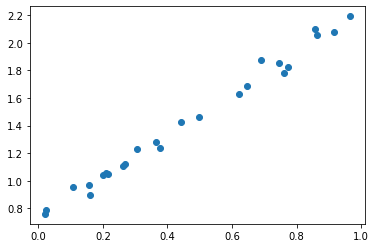

In [ ]:
#Plotear con matplotlib X vs Y
plt.scatter(X, Y)

* W es un vector de pesos con la forma (n, 1), que puede ser inicializado en 0 o aleatoriamente.

In [ ]:
#Vectorizar el problema
n = X.shape[0]
m = X.shape[1]
W = np.ones((n,1))
b = 0

0.9454462316


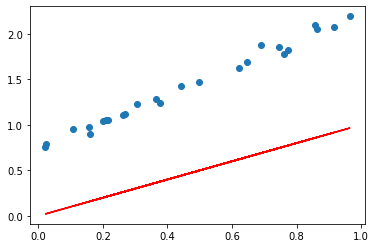

In [ ]:
#Probemos a predecir a partir del vector de pesos inicial...

A = np.dot(W.T, X) + b
L = np.sum(np.power(Y-A,2))/m
print(L)
plt.scatter(X, Y)
plt.plot(X[0], A[0], 'r-')


# AJUSTANDO LOS PESOS MEDIANTE DESCENSO POR GRADIENTE

Para obtener los pesos que minimicen el error aplicaremos la técnica iterativa conocida como descenso por gradiente.

<img src = res/height.png>


### REGLA DE ACTUALIZACIÓN DE PESOS:

Actualizaremos los pesos y el intercepto a partir de la siguiente regla:

$ W_{new} = W - \rho \Delta W $

$ b_{new} = b - \rho \Delta b $

Donde $\rho$ es una tasa de aprendizaje que determina qué tanto modificaremos los pesos según el valor de $\Delta W$.


### CALCULO DE $\Delta W$  y $\Delta b$

El cambio para un peso w está definido como la derivada parcial de la función de perdida $L$ con respecto a ese peso.

### $ \Delta w_j  = \frac{ \partial L }{\partial w_j}  $

Por regla de la cadena..
### $\frac{ \partial L }{\partial w_j}  = \frac{\partial a}{\partial w_j} \frac{\partial L}{\partial a} $



### $L = \frac{1}{m}  \sum_{i=1}^m (y_i - a_i)^2 $

### $\frac{ \partial L }{ \partial a} = - \frac{2}{m} \sum_{i=1}^m (y_i - a_i) $


### $a = \sum_{j=1}^n w_j x_j + b $

### $\frac{ \partial a }{ \partial w_j} = x_{i,j} $

### $\frac{ \partial L }{\partial w_j}  =  - \frac{2}{m} \sum_{i=1}^m (y_i - a_i)  x_{i,j} $

### $\frac{ \partial L }{\partial w_j}  =  - \frac{2}{m} \sum_{i=1}^m (y_i - a_i) x_{i,j} $

Lo anterior puede reducirse aplicando algebra matricial a...

### $\frac{ \partial L }{\partial W}  =  - \frac{2}{m}  (Y - A) \cdot X^T $

Y analogamente:

### $\frac{ \partial L }{\partial b}  =  - \frac{2}{m} \sum_{i=1}^m (y_i - a_i)  $

Nota: En el código denotaremos a cada derivada parcial como $\Delta denominador$

0.002087022798644724


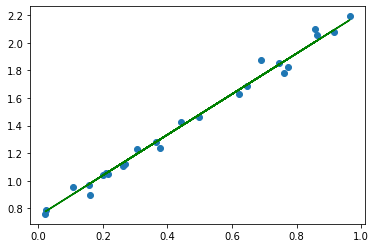

In [ ]:
#Realizar un ajuste de pesos sobre la regresión lineal hasta encontrar la línea
#que mejor se ajuste
n = X.shape[0]
m = X.shape[1]
W = np.ones((n,1))
b = 0
#Learning_rate o alpha debe ser relativamente pequeño para asegurar la convergencia del método
learning_rate = 0.001

#Realizar 10000 iteraciones
for i in range(10000):
    A = np.dot(W.T, X) + b


    dW = -(2/m) * ( np.dot(Y - A, X.T ))

    db = -(2/m) * np.sum( Y - A )

    W = W - learning_rate*dW
    b = b - learning_rate*db

    A = np.dot(W.T, X) + b
    L = np.sum(np.power(Y-A,2))/m

print(L)
plt.scatter(X, Y)
plt.plot(X[0], A[0], 'g-')



A continuación probemos el código desarrollado en el dataset de diabetes, y comparemos con la función implementada por Scikit-Learn...

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()

X = diabetes.data.T
Y = diabetes.target.reshape(1,len(diabetes.target))
n = X.shape[0]
m = X.shape[1]
W = np.ones((n,1))
b = 0
learning_rate = 0.3

losses = []

for i in range(100000):
    A = np.dot(W.T, X) + b
    dW = -(2/m) * ( np.dot(Y - A, X.T ))
    db = -(2/m) * np.sum( Y - A )

    W = W - learning_rate*dW.T
    b = b - learning_rate*db

    A = np.dot(W.T, X) + b
    L = np.sum(np.power(Y-A,2))/m
    losses.append(L)
print(L)
print(W)


2861.8848914859072
[[  -8.91315231]
 [-238.58518489]
 [ 522.6183413 ]
 [ 323.30152636]
 [-553.58466733]
 [ 287.42038705]
 [  -5.66530379]
 [ 146.61055298]
 [ 662.37304325]
 [  68.50422435]]


Text(0, 0.5, 'Perdida')

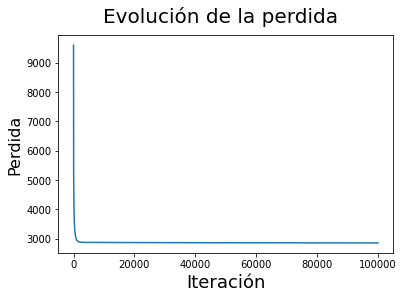

In [ ]:
fig = plt.figure()
plt.plot(losses)
fig.suptitle('Evolución de la perdida', fontsize=20)
plt.xlabel('Iteración', fontsize=18)
plt.ylabel('Perdida', fontsize=16)

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X.T, Y[0])

In [ ]:
A = reg.predict(X.T)
L = np.sum(np.power(Y-A,2))/m
print(L)
print(reg.coef_)

2859.69634758675
[ -10.0098663  -239.81564367  519.84592005  324.3846455  -792.17563855
  476.73902101  101.04326794  177.06323767  751.27369956   67.62669218]


# 5.1.4. REGRESIÓN LOGÍSTICA

La regresión logística se puede considerar una modificacón de la regresión lineal (modelo lineal generalizado). En este caso, en vez de predecir una variable de respuesta continua, se predice una variable de respuesta categórica, tal que:

## $z =  W^{T}X + b $

## $ a = \sigma(z)$
<br/>
Donde...

## $\sigma(z) = \frac{1}{1 + e^{-z}}$

<br/>

<img src = res/logistic.png>

Debido a la forma de la función sigmoidea, los valores resultantes están entre 0 y 1, lo que la hace muy útil para la tarea de clasificación binaria.

Considerando lo anterior se decide usar una función de perdida de entropía cruzada, definida como sigue para un conjunto de $m$ datos:

## $L = \frac{1}{m} \cdot \sum_{i=0}^{m-1} - y \cdot log(a) - (1-y) \cdot log(1- a)  $



In [ ]:
df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')
df_train = df_train.drop(columns=['Unnamed: 0'])
df_test =  df_test.drop(columns=['Unnamed: 0'])

In [ ]:
df_train = df_train.loc[df_train['class'].isin([0.0,1.0])]
df_train = df_train.dropna()
df_test = df_test.loc[df_test['class'].isin([0.0,1.0])]
df_test = df_test.dropna()

In [ ]:
X_train = df_train.values[:,:-1]
Y_train = df_train.values[:,-1]

X_train = X_train.T
Y_train = Y_train.reshape((1,len(Y_train)))

X_test = df_test.values[:,:-1]
Y_test = df_test.values[:,-1]

X_test = X_test.T
Y_test = Y_test.reshape((1,len(Y_test)))

A continuación implementamos la regresión logística. La derivación correspondiente se encuentra en el pdf adjunto "deriv_log.pdf"

In [ ]:
n = X_train.shape[0]
m = X_train.shape[1]
W = np.ones((n,1))
b = 0
learning_rate = 0.01
eps = 0.00000001
losses = []

Z = np.dot(W.T, X_train) + b
A = 1/(1+np.exp(-Z))
for i in range(100):

    dW = np.dot(X_train, (A-Y_train).T)
    db = np.sum(A-Y_train)
    W = W - learning_rate*dW
    b = b - learning_rate*db
    Z = np.dot(W.T, X_train) + b
    A = 1/(1+np.exp(-Z))
    L = -np.sum((Y_train*np.log(eps+A)+((1-Y_train)*np.log(eps+1-A))))/m
    losses.append(L)

Text(0, 0.5, 'Perdida')

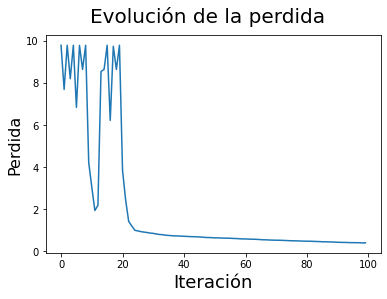

In [ ]:
fig = plt.figure()
plt.plot(losses)
fig.suptitle('Evolución de la perdida', fontsize=20)
plt.xlabel('Iteración', fontsize=18)
plt.ylabel('Perdida', fontsize=16)


In [ ]:
colnames = df_train.columns.values
weights = W.T[0]
print("Peso relacionado con cada atributo: ")
for i in range(len(colnames)-1):
    print(colnames[i],":\t", weights[i])

print("\n")

Z = np.dot(W.T, X_test) + b
A = 1/(1+np.exp(-Z))

A[A>0.5] = 1
A[A<=0.5] = 0



print("Casos mal clasificados sobre el conjunto de prueba: ", np.sum(np.abs(A-Y_test)), " de ", Y_test.shape[1])

Peso relacionado con cada atributo: 
hu0 :	 65.41496693110925
hu1 :	 1276.9433023949591
hu2 :	 -770.7882707886737
hu3 :	 -531.6106883803883
hu4 :	 8.613378274629387
hu5 :	 9.50033870070516
hu6 :	 -10.741249471205114
euler_num :	 939.5932767222872
orientation :	 109.85000752679761
area_to_convex_ratio :	 233.17344579767925
compacity :	 -411.40407911911836
roundness :	 195.99805806929734
area_perimeter_ratio :	 204.71542821878504
elongation :	 3178.8407694039797
solidity1 :	 233.17344579767925
solidity2 :	 403.18693729322234


Casos mal clasificados sobre el conjunto de prueba:  33.0  de  2109


In [ ]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression()
model.fit(X_train.T, Y_train[0])

LogisticRegression()

In [ ]:
colnames = df_train.columns.values
weights = model.coef_[0]
print("Peso relacionado con cada atributo: ")
for i in range(len(colnames)-1):
    print(colnames[i],":\t", weights[i])

Peso relacionado con cada atributo: 
hu0 :	 0.3170090062369767
hu1 :	 0.60274043856503
hu2 :	 0.9589800685940439
hu3 :	 -0.2768099756552851
hu4 :	 0.005340780410749471
hu5 :	 -0.007808643976346647
hu6 :	 -0.010662933979891326
euler_num :	 2.7888512609750613
orientation :	 1.38615814831496
area_to_convex_ratio :	 -1.4720281937703792
compacity :	 -0.10843202115998331
roundness :	 0.6232498740228902
area_perimeter_ratio :	 -0.4869030643703806
elongation :	 3.482391508285402
solidity1 :	 -1.4720281937703792
solidity2 :	 3.1386087372208142


In [ ]:
A = model.predict(X_test.T)
print("Casos mal clasificados sobre el conjunto de prueba: ", np.sum(np.abs(A-Y_test)), " de ", Y_test.shape[1])

Casos mal clasificados sobre el conjunto de prueba:  4.0  de  2109


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(A,Y_test[0])

array([[ 979,    3],
       [   1, 1126]], dtype=int64)

# Other algorithms

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

#realizar una lectura del dataset de iris
iris = load_iris()

X, y = iris.data, iris.target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


## Decision tree


In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))

Accuracy: 1.0
Precision: 1.0


In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Train the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1.0


In [ ]:
#Importar datasets preparados para trabajar
from keras.datasets import mnist

#Cargar el dataset, conjuntos de entrenamiento y pruebas
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)


0.8778


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(precision)
recall = metrics.recall_score(y_test, y_pred, average='macro')
print(recall)

0.8778
0.876224425883731
0.8762447265048209


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(precision)

0.5558
0.6864966027174797


## SVM

In [ ]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(precision)